# Examples illustrating hydrous melting

Simon Matthews, June 2022.

In pyMelt any (dry) lithology can be converted to a hydrous lithology under the assumptions of the hydrous melting model by Katz et al. (2003). For more information about the model please see this paper. Here we explore in more detail some of the consequences of the model for adiabatic decompression melting.

*Important note:* This notebook is more a thought experiment on the consequences of decompression *batch* melting of a hydrous lithology. This is very unlikely to ever represent a real scenario. Either melting will take place in the wedge above a subducting plate (for which pyMelt does not have a `geoSetting` class at the current time), or water will be quickly extracted as melts are removed by compaction (continuous melting, as described in the hydrous melting tutorial).

In [1]:
# import pyMelt as m
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%cd ../../
import pyMelt as m

/Users/simonmatthews/repos/pyMelt


In [3]:
lz = m.lithologies.matthews.klb1()

## What happens to the Solidus at high H$_2$O contents?

The introduction of water shifts the solidus to lower temperature, as determined by the expressions in Katz et al. (2003), up to the limit of fluid saturation. We can plot a diagram of how this works (very similar to a figure from Katz et al., 2003):

In [4]:
h2o = np.array([0.1, 0.2, 0.3, 1.0])
p = np.linspace(0, 8, 100)
tsol = np.zeros([np.shape(h2o)[0]+1, np.shape(p)[0]])

tsol[0, :] = lz.TSolidus(p)

for i in range(len(h2o)):
    hlz = m.hydrousLithology(lz, h2o[i])
    for j in range(len(p)):
        tsol[i+1, j] = hlz.TSolidus(p[j])

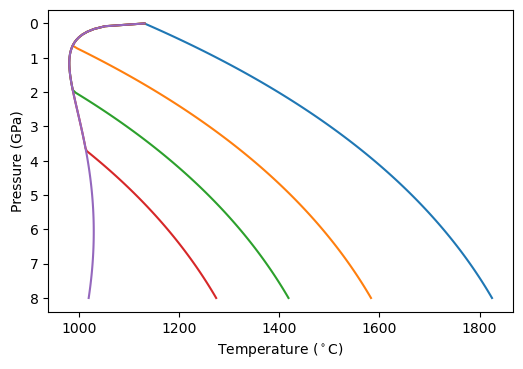

In [5]:
f,a = plt.subplots(dpi=100)

for i in range(np.shape(tsol)[0]):
    a.plot(tsol[i, :], p)
    
a.invert_yaxis()

a.set_ylabel('Pressure (GPa)')

a.set_xlabel('Temperature ($^\circ$C)')

plt.show()

The left-most line is the fluid saturated solidus, equating to higher and higher dissolved H$_2$O at increasing pressure. Note that the solidii show a dramatic shift from decreasing in temperature as pressure decreases, to increasing as pressure decreases. This has some interesting consequences for what would happen if you batch melted such a lithology during adiabatic decompression melting (see below).

## How do the melting expressions change during hydrous melting
The values for the partial and full differentials also change during melting, as a consequence of the change in solidus position. Katz et al. (2003) provided the analytical expression for some of the partial differentials, but pyMelt calculates them numerically. One of the advantages of using pyMelt via a python interface is that we can easily plot the values of these differentials and see how they are different from the dry melting case.

First we can calculate some melting regions (and extract some of the differentials):

In [61]:
h2o = np.array([0.05, 0.1, 0.15])
cols = []
Tp = 1300.0

mantle = m.mantle([lz], [1.0], ['lz'])
dry = mantle.adiabaticMelt(Tp, dP=-0.01)

dry_dTdF = np.zeros(len(dry.T))
dry_dTdP = np.zeros(len(dry.T))

for j in range(len(dry.T)):
    dry_dTdF[j] = lz.dTdF(dry.P[j], dry.T[j])
    dry_dTdP[j] = lz.dTdP(dry.P[j], dry.T[j])
    
dTdF = []
dTdP = []

for i in range(len(h2o)):
    hlz = m.hydrousLithology(lz, h2o[i])
    mantle = m.mantle([hlz], [1.0], ['lz'])
    cols.append(mantle.adiabaticMelt(Tp, dP=-0.01))
    
    wet_dTdF = np.zeros(len(cols[i].T))
    wet_dTdP = np.zeros(len(cols[i].T))
    
    for j in range(len(cols[i].T)):
        wet_dTdF[j] = hlz.dTdF(cols[i].P[j], cols[i].T[j])
        wet_dTdP[j] = hlz.dTdP(cols[i].P[j], cols[i].T[j])
    
    dTdF.append(wet_dTdF)
    dTdP.append(wet_dTdP)
    
    

Now we can plot the values of dF/dP and dT/dP that were used during the integration routine to get the geotherm and melt fraction evolution:

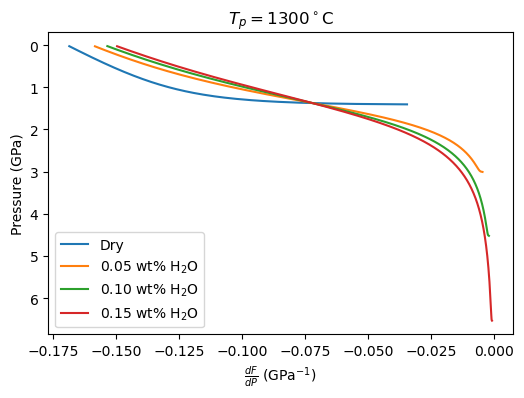

In [69]:
f, a = plt.subplots(dpi=100)

a.plot(-(np.array(dry.F[:-1]) - np.array(dry.F[1:]))/(dry.P[2]-dry.P[1]), dry.P[:-1], label='Dry')

for i in range(len(h2o)):
    a.plot(-(np.array(cols_freeze[i].F[:-1]) - np.array(cols_freeze[i].F[1:]))/(cols_freeze[i].P[2]-cols_freeze[i].P[1]), 
           cols_freeze[i].P[:-1],
           label='{:.2f} wt% H$_2$O'.format(h2o[i]))

    
a.legend()
           
a.set_ylabel('Pressure (GPa)')
a.set_xlabel(r'$\frac{dF}{dP}$ (GPa$^{-1}$)')

a.set_title('$T_p = 1300^\circ$C')
    
a.invert_yaxis()

plt.show()

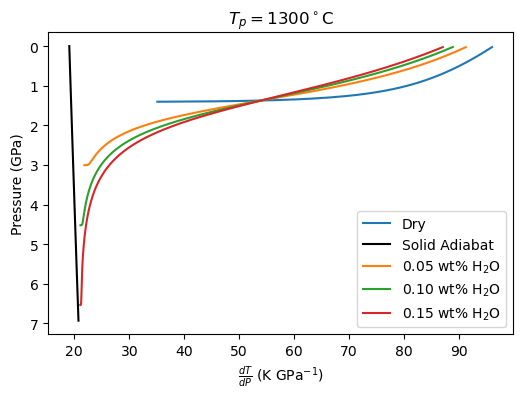

In [70]:
f, a = plt.subplots(dpi=100)

a.plot(-(np.array(dry.T[:-1]) - np.array(dry.T[1:]))/(dry.P[2]-dry.P[1]), dry.P[:-1], label='Dry')

pp = np.linspace(0, 7, 100)
# solid_adiabat = np.zeros(np.shape(pp))

solid_adiabat = mantle.adiabat(pp, Tp)


a.plot(-(solid_adiabat[:-1] - solid_adiabat[1:])/(pp[2]-pp[1]), pp[:-1], c='k', label='Solid Adiabat')

for i in range(len(h2o)):
    a.plot(-(np.array(cols_freeze[i].T[:-1]) - np.array(cols_freeze[i].T[1:]))/(cols_freeze[i].P[2]-cols_freeze[i].P[1]), 
           cols_freeze[i].P[:-1],
           label='{:.2f} wt% H$_2$O'.format(h2o[i]))

a.legend()
           
a.set_ylabel('Pressure (GPa)')
a.set_xlabel(r'$\frac{dT}{dP}$ (K GPa$^{-1}$)')

a.set_title('$T_p = 1300^\circ$C')
        

a.invert_yaxis()

plt.show()

Now we can plot the values of the partial derivatives (constant P.). In the Katz et al. (2003) model, these could be calculated analytically.

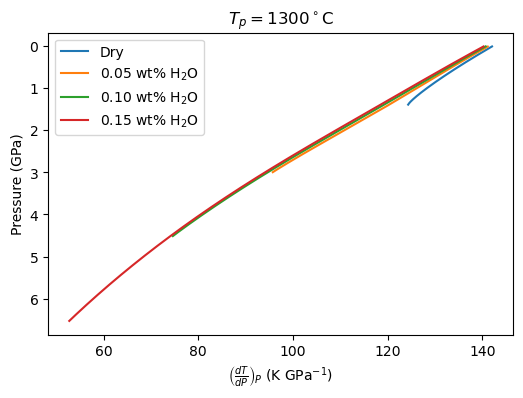

In [71]:
f, a = plt.subplots(dpi=100)

a.plot(dry_dTdP[1:], dry.P[1:], label='Dry')

for i in range(len(h2o)):
    a.plot(dTdP[i][1:], cols_freeze[i].P[1:], label='{:.2f} wt% H$_2$O'.format(h2o[i]))

a.invert_yaxis()

a.set_ylabel('Pressure (GPa)')
a.set_xlabel(r'$\left( \frac{dT}{dP} \right)_P$ (K GPa$^{-1}$)')

a.set_title('$T_p = 1300^\circ$C')

a.legend()

plt.show()

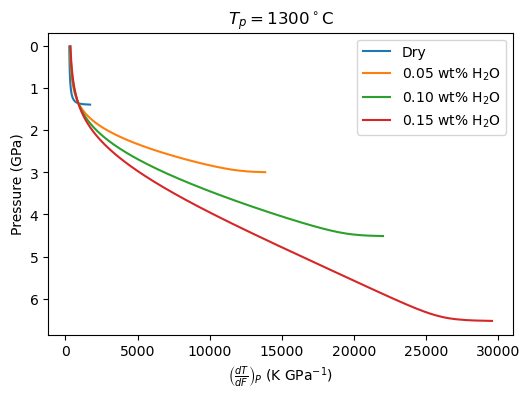

In [72]:
f, a = plt.subplots(dpi=100)

a.plot(dry_dTdF, dry.P, label='Dry')

for i in range(len(h2o)):
    a.plot(dTdF[i], cols_freeze[i].P, label='{:.2f} wt% H$_2$O'.format(h2o[i]))

a.invert_yaxis()

a.set_ylabel('Pressure (GPa)')
a.set_xlabel(r'$\left( \frac{dT}{dF} \right)_P$ (K GPa$^{-1}$)')

a.set_title('$T_p = 1300^\circ$C')

a.legend()

plt.show()

## What happens when you try to adiabatically decompress a H$_2$O saturated peridotite?

Disclaimer- this is a physically absurd situation (I think!), but pyMelt is designed to handle whatever lithology (and its melting behaviour) you give it, so let's put it to a test....

What we should expect to happen is that the mantle will be immediately molten (unless melting at a very low $T_p$) because the H$_2$O-saturated solidus has such a low temperature. This means at the start of the calculation we will have a hydrous melt + crystals + H$_2$O fluid. As it decompresses we might expect the melt fraction to increase and decrease according to the curvature of the solidus. At low pressures the solidus rapidly increases in temperature as the solubility of H$_2$O in melt drops. Physically this would correspond to the melt exsolving more fluid, while crystallising. This is not so dissimilar to degassing-driven crystallisation commonly seen in igneous rocks.

Hopefully this is what pyMelt will do!

In [6]:
hlz = m.hydrousLithology(lz, 10.0)

mantle = m.mantle([hlz], [1.0])

column = mantle.adiabaticMelt(1200.0)

/Users/simonmatthews/repos/pyMelt/pyMelt/lithologies/matthews.py:589: RuntimeWarning: invalid value encountered in log
  + self.parameters['A3'] * P + self.parameters['A4'])
/Users/simonmatthews/repos/pyMelt/pyMelt/lithology_classes.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return self.chi1 * P ** self.l + self.chi2 * P


InputError: No solidus intersection found. To model adiabatic decompression of solid mantle set a starting pressure using Pstart.

Ok... well this is telling us what we had expected- we are trying to start the calculation above the solidus. pyMelt can handle this by doing an interval of isobaric (entropy-conserved) melting, but we have to tell it to do this by giving it a starting pressure:

In [6]:
column = mantle.adiabaticMelt(1200.0, Pstart=8.0)

/Users/simonmatthews/repos/pyMelt/pyMelt/lithologies/matthews.py:589: RuntimeWarning: invalid value encountered in log
  + self.parameters['A3'] * P + self.parameters['A4'])
/Users/simonmatthews/repos/pyMelt/pyMelt/lithology_classes.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return self.chi1 * P ** self.l + self.chi2 * P
/Users/simonmatthews/repos/pyMelt/pyMelt/mantle_class.py:451: UserWarning: Super solidus start
  _warn("Super solidus start")
/Users/simonmatthews/repos/pyMelt/pyMelt/mantle_class.py:475: UserWarning: Freezing prevented.
  _warn("Freezing prevented.")


pyMelt warned us that it was crossing the solidus at the very start ("Super solidus start"), and then that it prevented freezing. The other RuntimeWarnings can be ignored, these will be fixed in a future update of pyMelt. Let's see what this looks like:

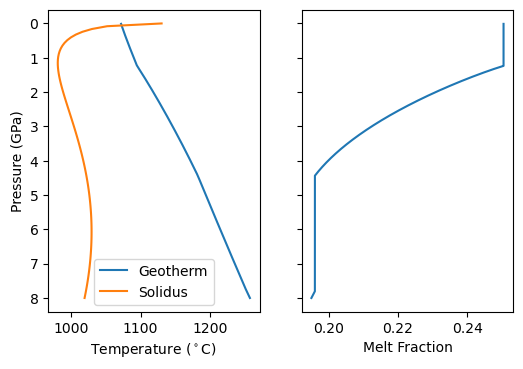

In [12]:
f, a = plt.subplots(1, 2, sharey='row', dpi=100)

a[0].plot(column.T, column.P, label='Geotherm')
a[0].plot(tsol[-1, :], p, label='Solidus')
a[1].plot(column.F, column.P)

a[0].invert_yaxis()

a[0].set_ylabel('Pressure (GPa)')
a[0].set_xlabel('Temperature ($^\circ$C)')
a[1].set_xlabel('Melt Fraction')

a[0].legend()


plt.show()

There are two intervals where $\frac{dF}{dP}=0$. One at depth, due to the curvature of the solidus, and one at lower pressure where the solidus starts rapidly increasing in temperature. What pyMelt did here was to observe that the model predicted $\frac{dF}{dP}>0$ (i.e., freezing) and then set $\frac{dF}{dP}=0$  and continued the calculation. It might seem like an odd thing for it to do- so why does it do this? Often we are using pyMelt to model a system where we are removing melt as the mantle upwells. In this case, the melts we have produced can no longer react with the solid and refreeze. This is actually inconsistent with the basis (equilibrium melting) on which the models are calibrated, but it is a pragmatic approach to applying them in *most* situations. Furthermore, to do chemistry calculations pyMelt requires a monotonically increasing melt fraction. However, it doesn't make much sense in this situation! We are assuming the bulk H$_2$O content remains in the system.

But... we can tell pyMelt not to do this (`prevent_freezing=False`), which is what we want for our conceptual model!

In [8]:
mantle = m.mantle([hlz], [1.0])

column_freezing = mantle.adiabaticMelt(1200.0, Pstart=8.0, prevent_freezing=False)

/Users/simonmatthews/repos/pyMelt/pyMelt/lithologies/matthews.py:589: RuntimeWarning: invalid value encountered in log
  + self.parameters['A3'] * P + self.parameters['A4'])
/Users/simonmatthews/repos/pyMelt/pyMelt/lithology_classes.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return self.chi1 * P ** self.l + self.chi2 * P
/Users/simonmatthews/repos/pyMelt/pyMelt/mantle_class.py:451: UserWarning: Super solidus start
  _warn("Super solidus start")


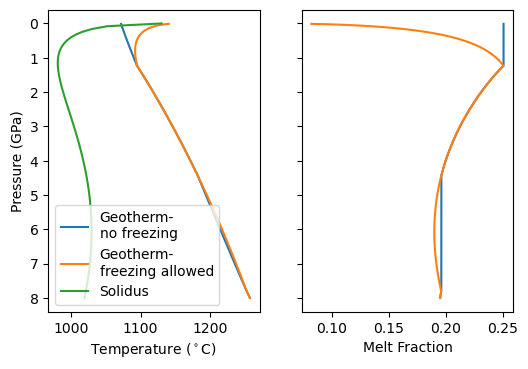

In [13]:
f, a = plt.subplots(1, 2, sharey='row', dpi=100)

a[0].plot(column.T, column.P, label='Geotherm-\nno freezing')
a[0].plot(column_freezing.T, column_freezing.P, label='Geotherm-\nfreezing allowed')
a[0].plot(tsol[-1, :], p, label='Solidus')
a[1].plot(column.F, column.P)
a[1].plot(column_freezing.F, column_freezing.P)


a[0].set_ylabel('Pressure (GPa)')
a[0].set_xlabel('Temperature ($^\circ$C)')
a[1].set_xlabel('Melt Fraction')

a[0].legend()

a[0].invert_yaxis()

plt.show()

Now we see that the model predicts a small amount of freezing during deep upwelling, followed by more melting. Finally the melt fraction crashes towards zero as H$_2$O begins to be exsolved. At the same time the temperature of geotherm starts *increasing*! Why? Because of the latent heat released by solidification. This extra heat prevents the mantle from completely crossing the solidus and solidifying.